## Imports and Helper Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [13]:
def plot_garage_data_over_time(df, feature_to_plot, individual_plots=False):
    # get list of unique garages
    unique_garagecodes = df['garagecode'].unique().tolist()

    if individual_plots:
        # 8 individual plots
        for garage in unique_garagecodes:
            filtered_df = df[df['garagecode'] == garage]

            sns.lineplot(x='update_dt', y=feature_to_plot, data=filtered_df)
            plt.title(garage)
            plt.show()

    else:
        # 1 plot with 4x2 subplots
        row_count = 4
        col_count = 2

        fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(12,16))

        for i, garage in enumerate(unique_garagecodes):
            row = i // col_count
            col = i % col_count
            filtered_df = df[df['garagecode'] == garage]

            sns.lineplot(x='update_dt', y=feature_to_plot, data=filtered_df, ax=axes[row, col])
            axes[row, col].set_title(garage)

        plt.suptitle(f'{feature_to_plot} over Time')
        plt.tight_layout()
        plt.show()

## Loading and cleaning data

In [3]:
file = 'aarhus_parking.csv'
df_raw = pd.read_csv(file)

df_raw.head(10)

,vehiclecount,updatetime,_id,totalspaces,garagecode,streamtime
0,0,2014-05-22 09:09:04.145,1,65,NORREPORT,2014-11-03 16:18:44
1,0,2014-05-22 09:09:04.145,2,512,SKOLEBAKKEN,2014-11-03 16:18:44
2,869,2014-05-22 09:09:04.145,3,1240,SCANDCENTER,2014-11-03 16:18:44
3,22,2014-05-22 09:09:04.145,4,953,BRUUNS,2014-11-03 16:18:44
4,124,2014-05-22 09:09:04.145,5,130,BUSGADEHUSET,2014-11-03 16:18:44
5,106,2014-05-22 09:09:04.145,6,400,MAGASIN,2014-11-03 16:18:44
6,115,2014-05-22 09:09:04.145,7,210,KALKVAERKSVEJ,2014-11-03 16:18:44
7,233,2014-05-22 09:09:04.145,8,700,SALLING,2014-11-03 16:18:44
8,0,2014-05-22 09:39:01.803,9,65,NORREPORT,2014-11-03 16:18:44
9,0,2014-05-22 09:39:01.803,10,512,SKOLEBAKKEN,2014-11-03 16:18:44


In [4]:
df_raw.describe()

,vehiclecount,_id,totalspaces
count,55264.000000,55264.000000,55264.000000
mean,192.188387,27667.796468,526.250000
std,210.500021,15959.295617,388.536895
min,0.000000,1.000000,65.000000
25%,32.000000,13855.750000,190.000000
50%,96.000000,27671.500000,456.000000
75%,296.000000,41487.250000,763.250000
max,1464.000000,55303.000000,1240.000000


In [5]:
df_raw.dtypes

vehiclecount     int64
updatetime      object
_id              int64
totalspaces      int64
garagecode      object
streamtime      object
dtype: object

In [6]:
df = df_raw.copy()

As seen above in the dataframe head and description, the '_id' column serves purely as a means to track the updates sent to the main database and is redundant to the data's index.

In [7]:
df = df.drop(columns=['_id'])

### Datetime data

In [8]:
# set time columns to datetimes
df['update_dt'] = pd.to_datetime(df['updatetime'])
df['stream_dt'] = pd.to_datetime(df['streamtime'])

df = df.drop(columns=['updatetime', 'streamtime'])

In [9]:
df[['update_dt', 'stream_dt']].describe()

,update_dt,stream_dt
count,55264,55264
unique,6908,47
top,2014-05-22 09:09:04.145000,2014-11-03 16:18:44
freq,8,10000
first,2014-05-22 09:09:04.145000,2014-11-03 16:18:44
last,2014-11-04 14:13:47.581000,2014-11-04 14:20:03


The streamtime feature tracks only when the data was collected from each garage and sent to the main database, and does not reflect the changing parking capacity of the garages over time. Thus the feature will not be needed for predictive modeling, and will be dropped from the cleaned dataset.

In [10]:
df = df.drop(columns=['stream_dt'])

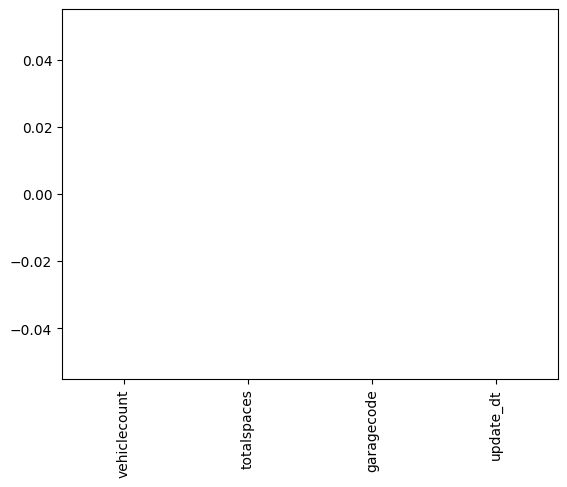

In [11]:
# check for NA values
df.isna().sum().plot.bar()
plt.show()

### Visualize parking data over time at each garage

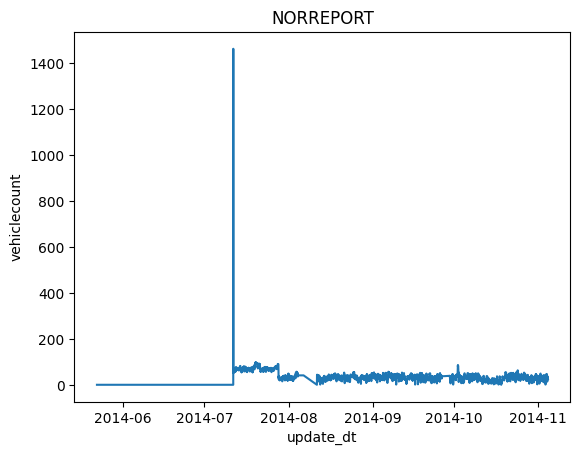

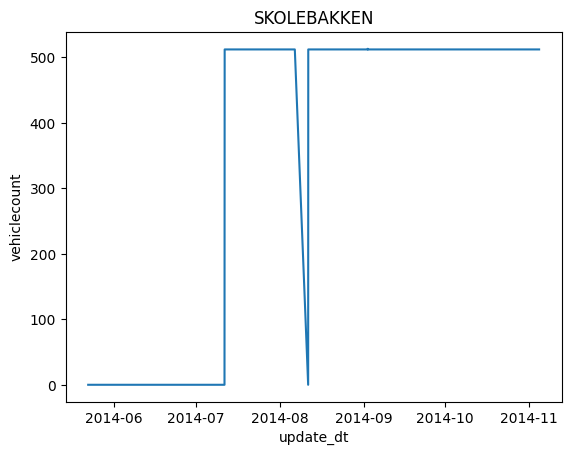

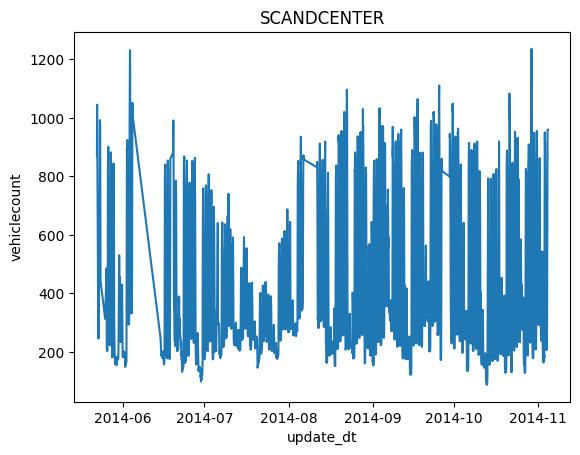

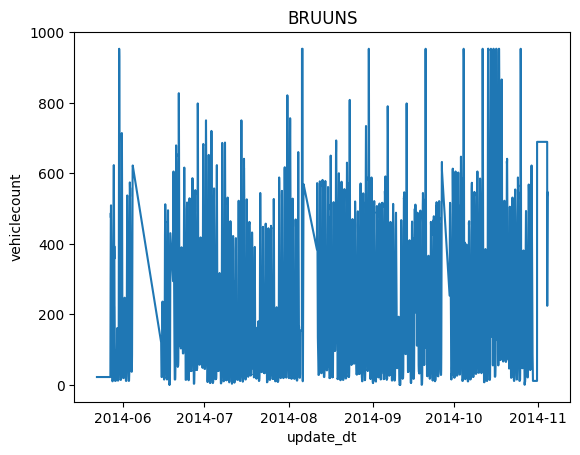

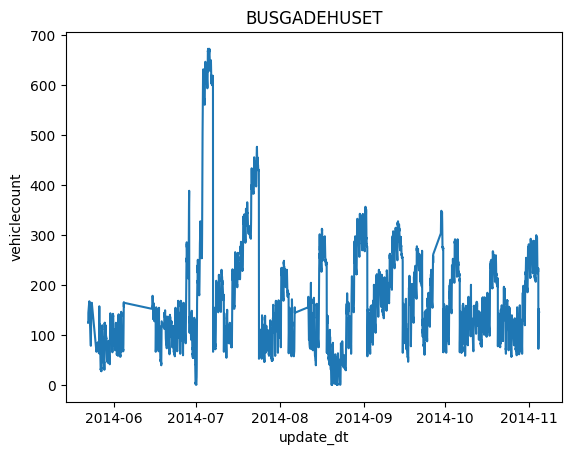

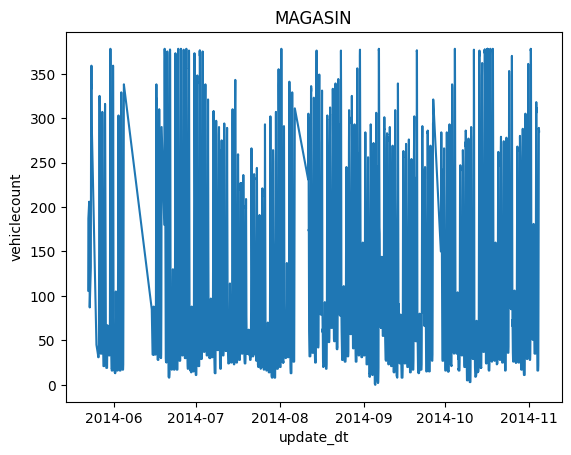

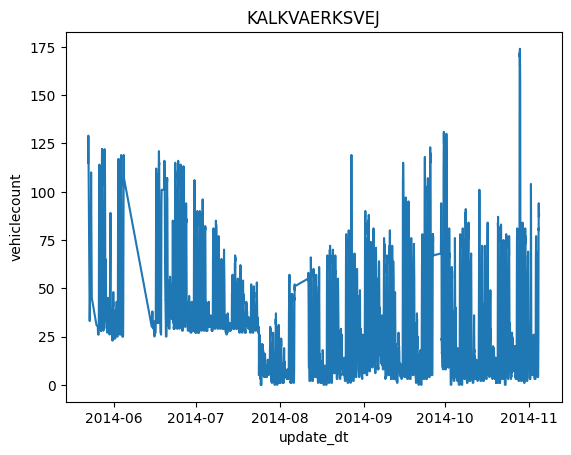

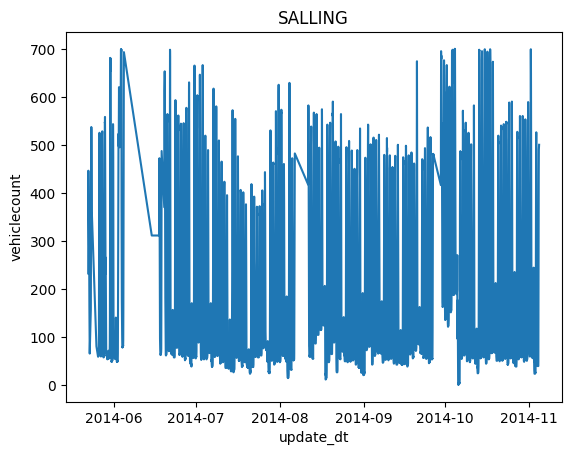

In [19]:
plot_garage_data_over_time(df, 'vehiclecount', individual_plots=True)

The data for garage 'Skolebakken' appears to be inaccurate and will not be useful in training a predictive model. As such, this garage will be dropped from the dataset.  
Additionally, prior to ~ mid July, the garage at Norreport does not appear to be accurately tracking the number of available parking spaces. The data prior to this cutoff, specifically for the Norreport garage, will also be dropped.

In [58]:
# drop skolebakken data
df = df[df['garagecode'] != 'SKOLEBAKKEN']

In [59]:
df[df['garagecode'] == 'NORREPORT'].describe()

,vehiclecount,totalspaces
count,6908.000000,6908.0
mean,29.277794,65.0
std,28.587276,0.0
min,0.000000,65.0
25%,1.000000,65.0
50%,30.000000,65.0
75%,41.000000,65.0
max,1464.000000,65.0


In [60]:
# with the spike in data identified from the .describe() above, we can find the date which the spike occurred
df[df['vehiclecount'] == 1464]

,vehiclecount,totalspaces,garagecode,update_dt
13760,1464,65,NORREPORT,2014-07-11 15:26:49.612


In [61]:
# drop all data points for norreport which occurred prior to 2014-07-12
df = df[(df['garagecode'] != 'NORREPORT') | (df['update_dt'] >= '2014-07-12')]

In [62]:
df.columns

Index(['vehiclecount', 'totalspaces', 'garagecode', 'update_dt'], dtype='object')

## Feature extraction

### Datetime

In [63]:
# extract date and time as individual features
df['date'] = df['update_dt'].dt.date
df['time'] = df['update_dt'].dt.time

In [64]:
# Extracting more from the date
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.weekday
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

The extracted datetime information will be further modified through cyclic encoding. Cyclic encoding can be beneficial within time series modeling and predictions to indicate the cyclic nature of certain features such as the time of day, day of the week or month, or month of the year. Rather than existing on a linear scale, these features occur in a cyclic pattern, and can potentially help a model to better account for patterns occurring over time.

In [65]:
# cyclic encoding of datetime information
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['time_sin'] = np.sin(2 * np.pi * (df['time'].apply(lambda x: x.hour) * 60 + df['time'].apply(lambda x: x.minute)) / (24 * 60))
df['time_cos'] = np.cos(2 * np.pi * (df['time'].apply(lambda x: x.hour) * 60 + df['time'].apply(lambda x: x.minute)) / (24 * 60))

### Parking data

The parking data is currently tracked as the number of occupied spaces (vehiclecount), and as the total number of spaces (totalspaces). However, in order to potentially improve model generalization across multiple garages, an additional feature can be extracted, which is the garage's current capacity as a percentage. I.e a garage that is full would have a capacity of 1, and a garage which is empty would have a capacity of 0.

In [17]:
df['capacity'] = df['vehiclecount'] / df['totalspaces']

In [67]:
df.head()

,vehiclecount,totalspaces,garagecode,update_dt,date,time,weekday,day,month,year,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos,capacity
2,869,1240,SCANDCENTER,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.700806
3,22,953,BRUUNS,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.023085
4,124,130,BUSGADEHUSET,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.953846
5,106,400,MAGASIN,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.265000
6,115,210,KALKVAERKSVEJ,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,0.433884,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.547619


### Visualizing capacity over time

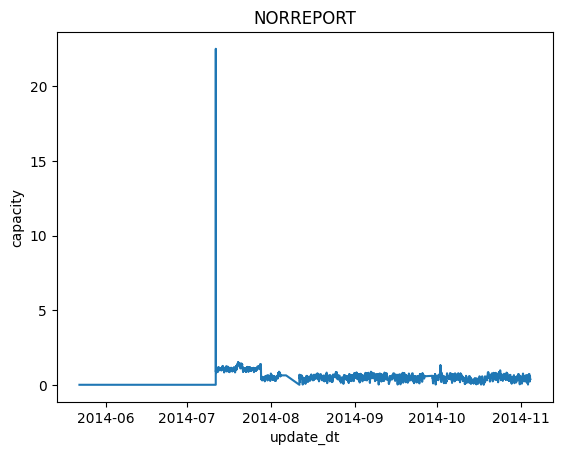

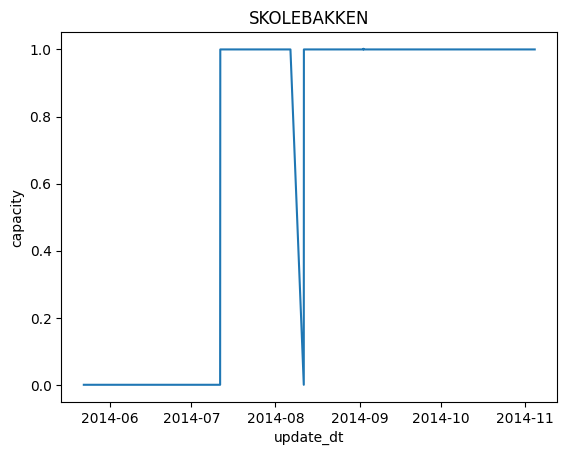

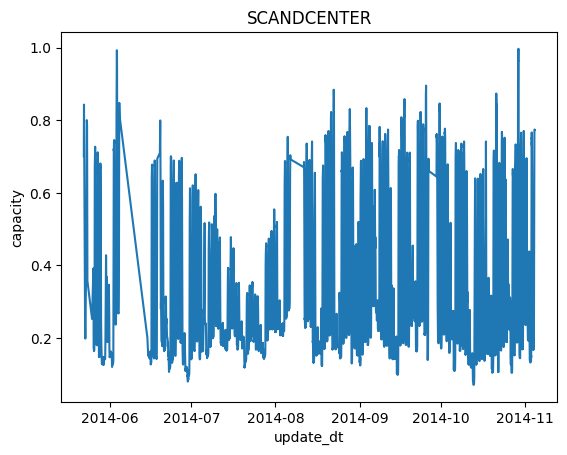

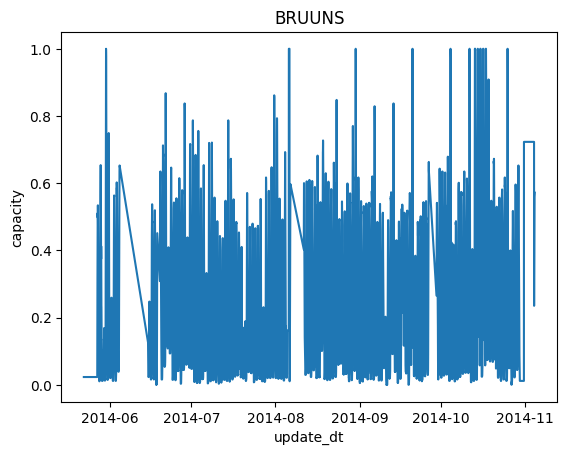

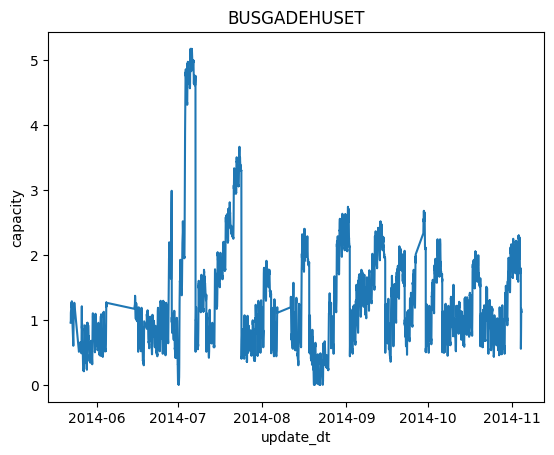

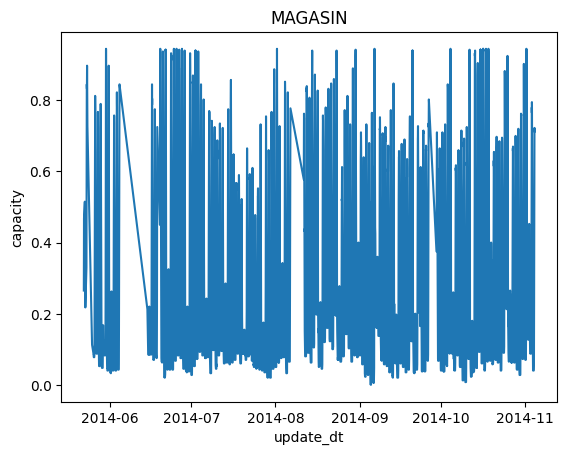

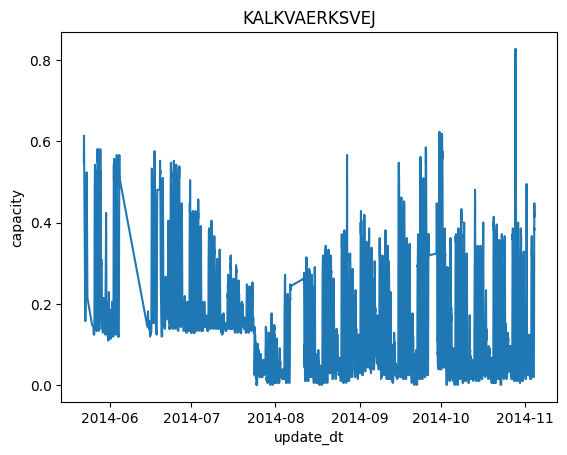

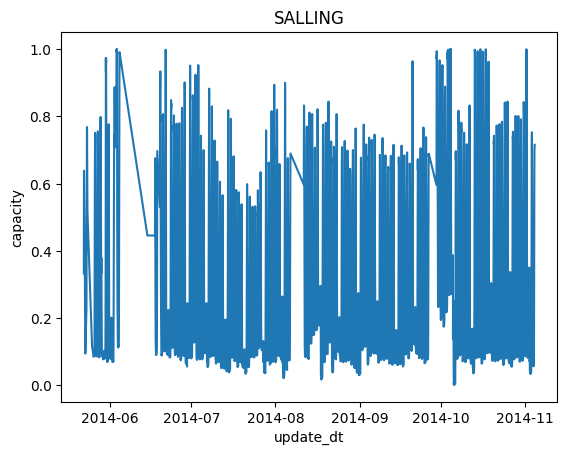

In [18]:
plot_garage_data_over_time(df, 'capacity', individual_plots=True)

Visualizing the capacity of the garages over time, the Busgadehuset garage is regularly significantly over capacity. Having verified the max vehicle capacity for this garage is accurate in the dataset, this garage will be dropped from the dataframe.

In [69]:
df = df[df['garagecode'] != 'BUSGADEHUSET']

In [70]:
df.to_csv('parking_data_cleaned.csv', index=False)

## Modeling prep

For modeling we will need to create sequences of data for each unique garage.  
First separate dataframes will be made for each garage. Next, each garage's dataframe can be split in to training and testing data sets (80/20). Then sequences can be made from the training and testing data.

In [71]:
# load cleaned dataset
df = pd.read_csv('parking_data_cleaned.csv')

In [72]:
# create list of individual DFs for each garage for training and testing
unique_garagecodes = df['garagecode'].unique().tolist()

train_dfs = []
test_dfs = []

train_size = .8
test_size = 1 - train_size

for garage in unique_garagecodes:
    # isolate garage
    temp_df = df[df['garagecode'] == garage]
    # split garage df into train and test
    size = len(temp_df)
    train_df = temp_df.head(int(size * train_size))
    test_df = temp_df.tail(int(size * test_size))
    # reset index
    train_df = train_df.reset_index()
    test_df = test_df.reset_index()
    # append garage dfs to master lists
    train_dfs.append(train_df)
    test_dfs.append(test_df)

In [74]:
df.columns

Index(['vehiclecount', 'totalspaces', 'garagecode', 'update_dt', 'date',
       'time', 'weekday', 'day', 'month', 'year', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'time_sin', 'time_cos',
       'capacity'],
      dtype='object')

In [75]:
# create target cols list
target_cols = ['capacity']

# create feature cols list
feat_cols = df.columns
feat_cols = feat_cols.drop(['vehiclecount', 'totalspaces', 'garagecode', 'update_dt', 'date', 'time', 'weekday', 'day', 'month', 'year'])
feat_cols = feat_cols.to_list()

The parking structure updates its current vehicle count in 30 minute increments. With that in mind, the first prediction we will try to make is the parking structure capacity 30 minutes (1 time step) in the future. We will begin with using the past 5 time steps (2.5 hours) to make the prediction.

In [76]:
# training sequencing!
input_seqs = []
outputs = []

seq_length = 8
ph = 1

for df in train_dfs:
    for i in range(len(df) - seq_length - ph):
        seq = df[feat_cols].iloc[i:i+seq_length]
        target = df[target_cols].iloc[i+seq_length+ph-1]

        input_seqs.append(seq)
        outputs.append(target)

input_seqs = np.array(input_seqs, dtype=object).astype(np.float32)
outputs = np.array(outputs, dtype=object).astype(np.float32)

print(f'input data shape: {input_seqs.shape}')
print(f'target shape: {outputs.shape}')

input data shape: (31712, 8, 9)
target shape: (31712, 1)


In [77]:
outputs = outputs.reshape(-1)

In [110]:
# test data sequencing
# arrays for all garage data testing at once
test_seqs_all_garages = []
test_outputs_all_garages = []
# lists to contain arrays to test garages individually
test_seqs_sep_garages = []
test_outputs_sep_garages = []
# df for exporting data to Tableau
export_df = pd.DataFrame()

for df in test_dfs:
    # sub arrays for separate garage data
    test_seqs = []
    test_outputs = []
    for i in range(seq_length, len(df) - ph):
        # sequencing
        seq = df[feat_cols].iloc[i-seq_length: i]
        full_target_data = df.iloc[i+ph-1]
        target = full_target_data[target_cols]
        # save export data
        export_df = export_df.append(full_target_data, ignore_index=True)

        test_seqs.append(seq)
        test_outputs.append(target)

        # append data for all garage testing
        test_seqs_all_garages.append(target)
        test_outputs_all_garages.append(target)

    # convert sub arrays to numpy arrays and append arrays to lists
    test_seqs = np.array(test_seqs, dtype=object).astype(np.float32)
    test_outputs = np.array(test_outputs, dtype=object).astype(np.float32)
    test_seqs_sep_garages.append(test_seqs)
    test_outputs_sep_garages.append(test_outputs)

# convert full garage testing data to arrays
test_seqs_all_garages = np.array(test_seqs, dtype=object).astype(np.float32)
test_outputs_all_garages = np.array(test_outputs, dtype=object).astype(np.float32)

In [119]:
export_df = export_df.drop(columns=['index', 'date',
       'time', 'weekday', 'day', 'month', 'year', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'time_sin', 'time_cos'])

In [80]:
export_df

,vehiclecount,totalspaces,garagecode,update_dt,capacity
0,232,1240,SCANDCENTER,2014-10-06 23:31:50.203,0.187097
1,231,1240,SCANDCENTER,2014-10-07 00:01:50.213,0.186290
2,231,1240,SCANDCENTER,2014-10-07 00:31:50.227,0.186290
3,230,1240,SCANDCENTER,2014-10-07 01:01:50.212,0.185484
4,230,1240,SCANDCENTER,2014-10-07 01:31:50.204,0.185484
...,...,...,...,...,...
7879,28,65,NORREPORT,2014-11-04 09:43:47.589,0.430769
7880,31,65,NORREPORT,2014-11-04 10:13:47.590,0.476923
7881,37,65,NORREPORT,2014-11-04 10:59:35.090,0.569231
7882,34,65,NORREPORT,2014-11-04 11:13:47.572,0.523077


## Modeling

LSTM model:  
- LSTM (10 nodes, relu activation)
- Dropout (.2)
- LSTM (5 nodes)
- Dropout (.2)
- Dense (1)
- Optimizer: adam, loss: MSE

In [95]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

tf.random.set_seed(1337)

In [96]:
model_path = 'LSTM_base_model.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=0)

model = Sequential()

model.add(LSTM( input_shape=(input_seqs.shape[1], input_seqs.shape[2]),
                units=10,
                activation='relu',
                return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM( units=5,
                activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,
                activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8, 10)             800       
                                                                 
 dropout_16 (Dropout)        (None, 8, 10)             0         
                                                                 
 lstm_17 (LSTM)              (None, 5)                 320       
                                                                 
 dropout_17 (Dropout)        (None, 5)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,126
Trainable params: 1,126
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
epochs = 100
batch_size = 32
val_size = 0.1

In [98]:
history = model.fit(input_seqs, 
                    outputs, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=val_size, 
                    verbose=2,
                    callbacks = [early_stopping, checkpoint])

Epoch 1/100
892/892 - 5s - loss: 0.0319 - val_loss: 0.0470 - 5s/epoch - 6ms/step
Epoch 2/100
892/892 - 3s - loss: 0.0147 - val_loss: 0.0275 - 3s/epoch - 3ms/step
Epoch 3/100
892/892 - 3s - loss: 0.0118 - val_loss: 0.0217 - 3s/epoch - 3ms/step
Epoch 4/100
892/892 - 3s - loss: 0.0105 - val_loss: 0.0165 - 3s/epoch - 3ms/step
Epoch 5/100
892/892 - 3s - loss: 0.0096 - val_loss: 0.0135 - 3s/epoch - 4ms/step
Epoch 6/100
892/892 - 3s - loss: 0.0090 - val_loss: 0.0135 - 3s/epoch - 4ms/step
Epoch 7/100
892/892 - 3s - loss: 0.0088 - val_loss: 0.0130 - 3s/epoch - 3ms/step
Epoch 8/100
892/892 - 3s - loss: 0.0087 - val_loss: 0.0109 - 3s/epoch - 3ms/step
Epoch 9/100
892/892 - 3s - loss: 0.0084 - val_loss: 0.0107 - 3s/epoch - 3ms/step
Epoch 10/100
892/892 - 3s - loss: 0.0083 - val_loss: 0.0097 - 3s/epoch - 3ms/step
Epoch 11/100
892/892 - 3s - loss: 0.0081 - val_loss: 0.0092 - 3s/epoch - 3ms/step
Epoch 12/100
892/892 - 3s - loss: 0.0079 - val_loss: 0.0094 - 3s/epoch - 3ms/step
Epoch 13/100
892/892 - 3s

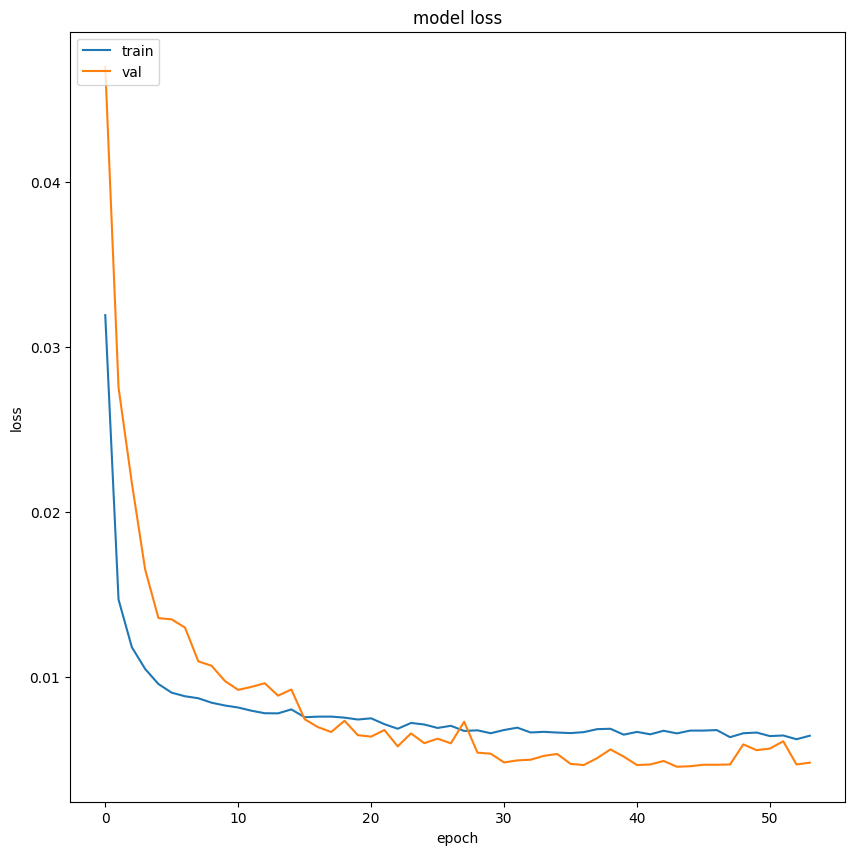

In [99]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [153]:
# all garages together performance
print('All garages tested at once')
scores_test = model.evaluate(test_seqs_all_garages, test_outputs_all_garages, verbose=2)
print(f'MSE: {scores_test}\n')

# garages tested separately
for i, garage in enumerate(unique_garagecodes):
    print(garage)
    seqs = test_seqs_sep_garages[i]
    outputs = test_outputs_sep_garages[i]
    scores_test = model.evaluate(seqs, outputs, verbose=2)
    print(f'MSE: {scores_test}\n')

All garages tested at once
32/32 - 0s - loss: 0.0049 - 49ms/epoch - 2ms/step
MSE: 0.004912210162729025

SCANDCENTER
43/43 - 0s - loss: 0.0014 - 69ms/epoch - 2ms/step
MSE: 0.0014054669300094247

BRUUNS
43/43 - 0s - loss: 0.0026 - 69ms/epoch - 2ms/step
MSE: 0.002608169335871935

MAGASIN
43/43 - 0s - loss: 0.0020 - 64ms/epoch - 1ms/step
MSE: 0.001963552087545395

KALKVAERKSVEJ
43/43 - 0s - loss: 0.0010 - 66ms/epoch - 2ms/step
MSE: 0.0010329068172723055

SALLING
43/43 - 0s - loss: 0.0018 - 61ms/epoch - 1ms/step
MSE: 0.0018393128411844373

NORREPORT
32/32 - 0s - loss: 0.0049 - 49ms/epoch - 2ms/step
MSE: 0.004912210162729025



In [154]:
# add predictions to export df
for i, garage in enumerate(unique_garagecodes):
    seqs = test_seqs_sep_garages[i]
    outputs = test_outputs_sep_garages[i]
    y_pred_test = model.predict(seqs)

    export_df.loc[export_df['garagecode'] == garage, 'prediction'] = y_pred_test

32/32 [==============================] - 0s 1ms/step


In [155]:
export_df['predicted_vehicle_count'] = (export_df['totalspaces'] * export_df['prediction']).astype(int)
export_df['predicted_available_spaces'] = export_df['totalspaces'] - export_df['predicted_vehicle_count']
export_df['available_spaces'] = export_df['totalspaces'] - export_df['vehiclecount']
export_df['update_dt'] = pd.to_datetime(export_df['update_dt'])

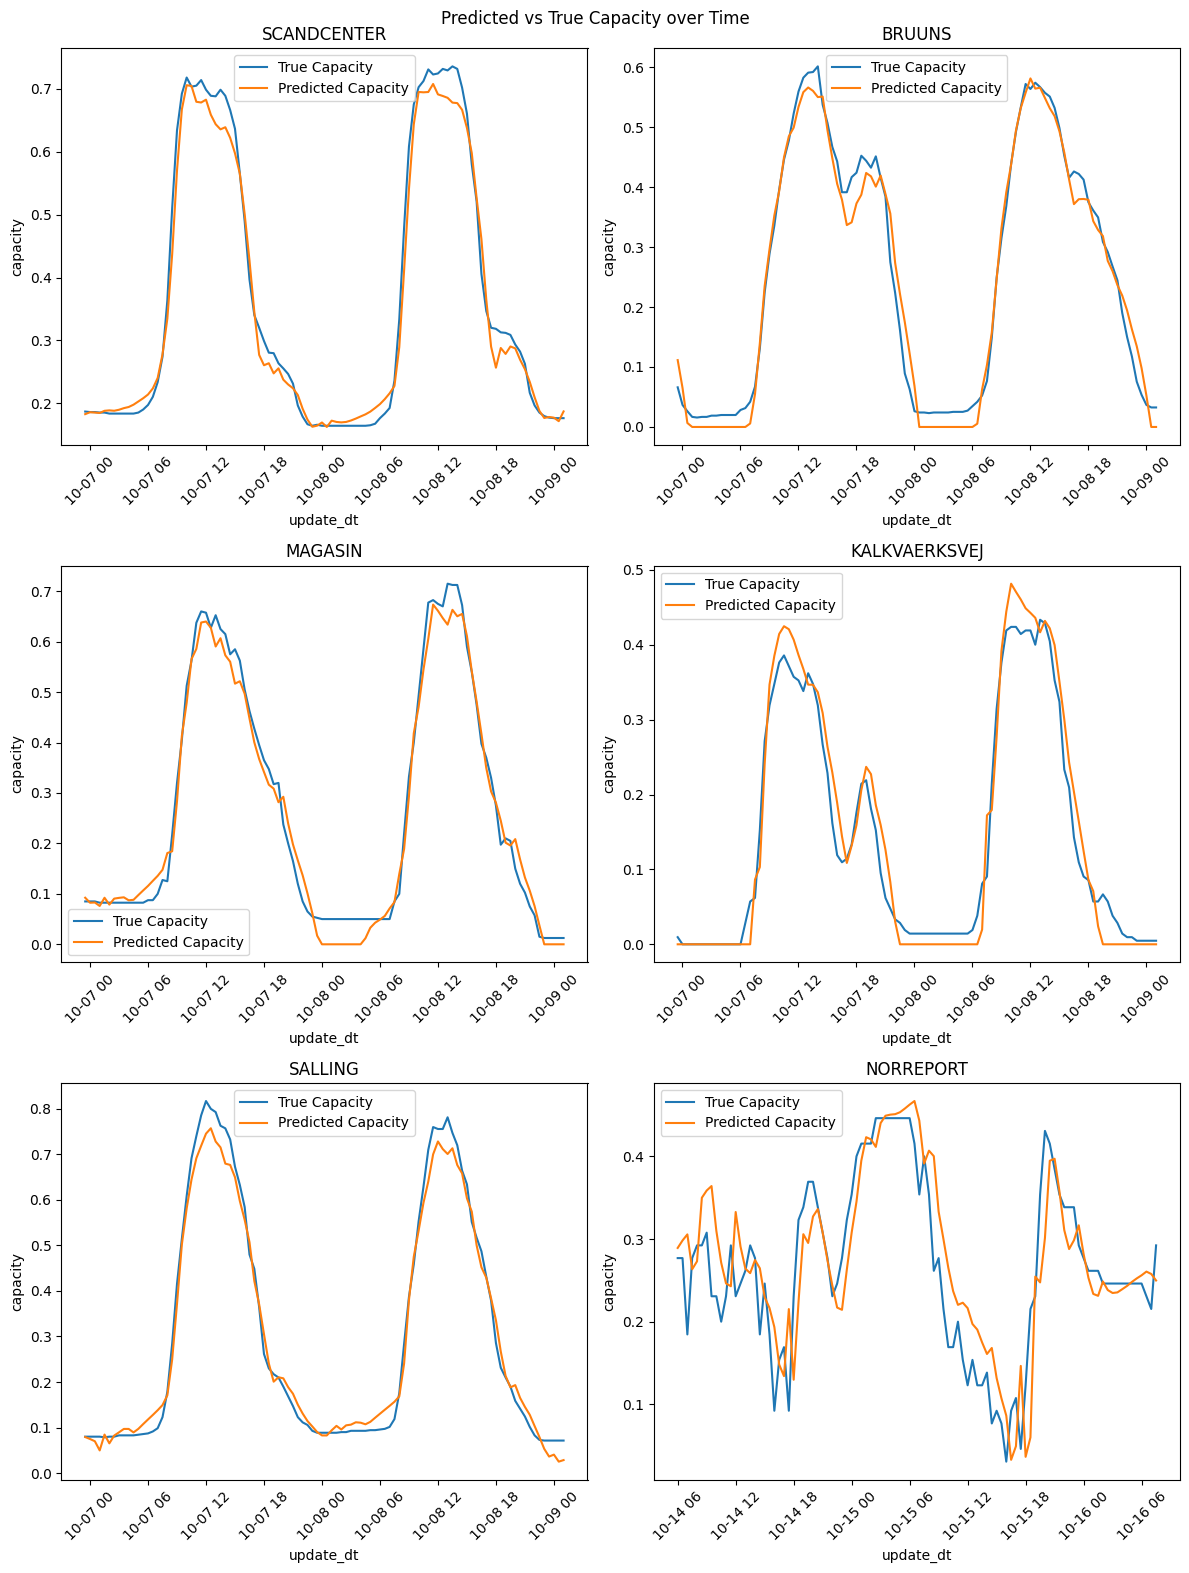

In [34]:
# plot predictions
row_count = 3
col_count = 2
n_predictions = 100

fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(12,16))

for i, garage in enumerate(unique_garagecodes):
    row = i // col_count
    col = i % col_count
    filtered_df = export_df[export_df['garagecode'] == garage].head(n_predictions)

    sns.lineplot(x='update_dt', y='capacity', data=filtered_df, ax=axes[row, col], label='True Capacity')
    sns.lineplot(x='update_dt', y='prediction', data=filtered_df, ax=axes[row, col], label='Predicted Capacity')
    axes[row, col].set_title(garage)
    axes[row, col].tick_params(axis='x', rotation=45)


plt.suptitle('Predicted vs True Capacity over Time')
plt.tight_layout()
plt.show()

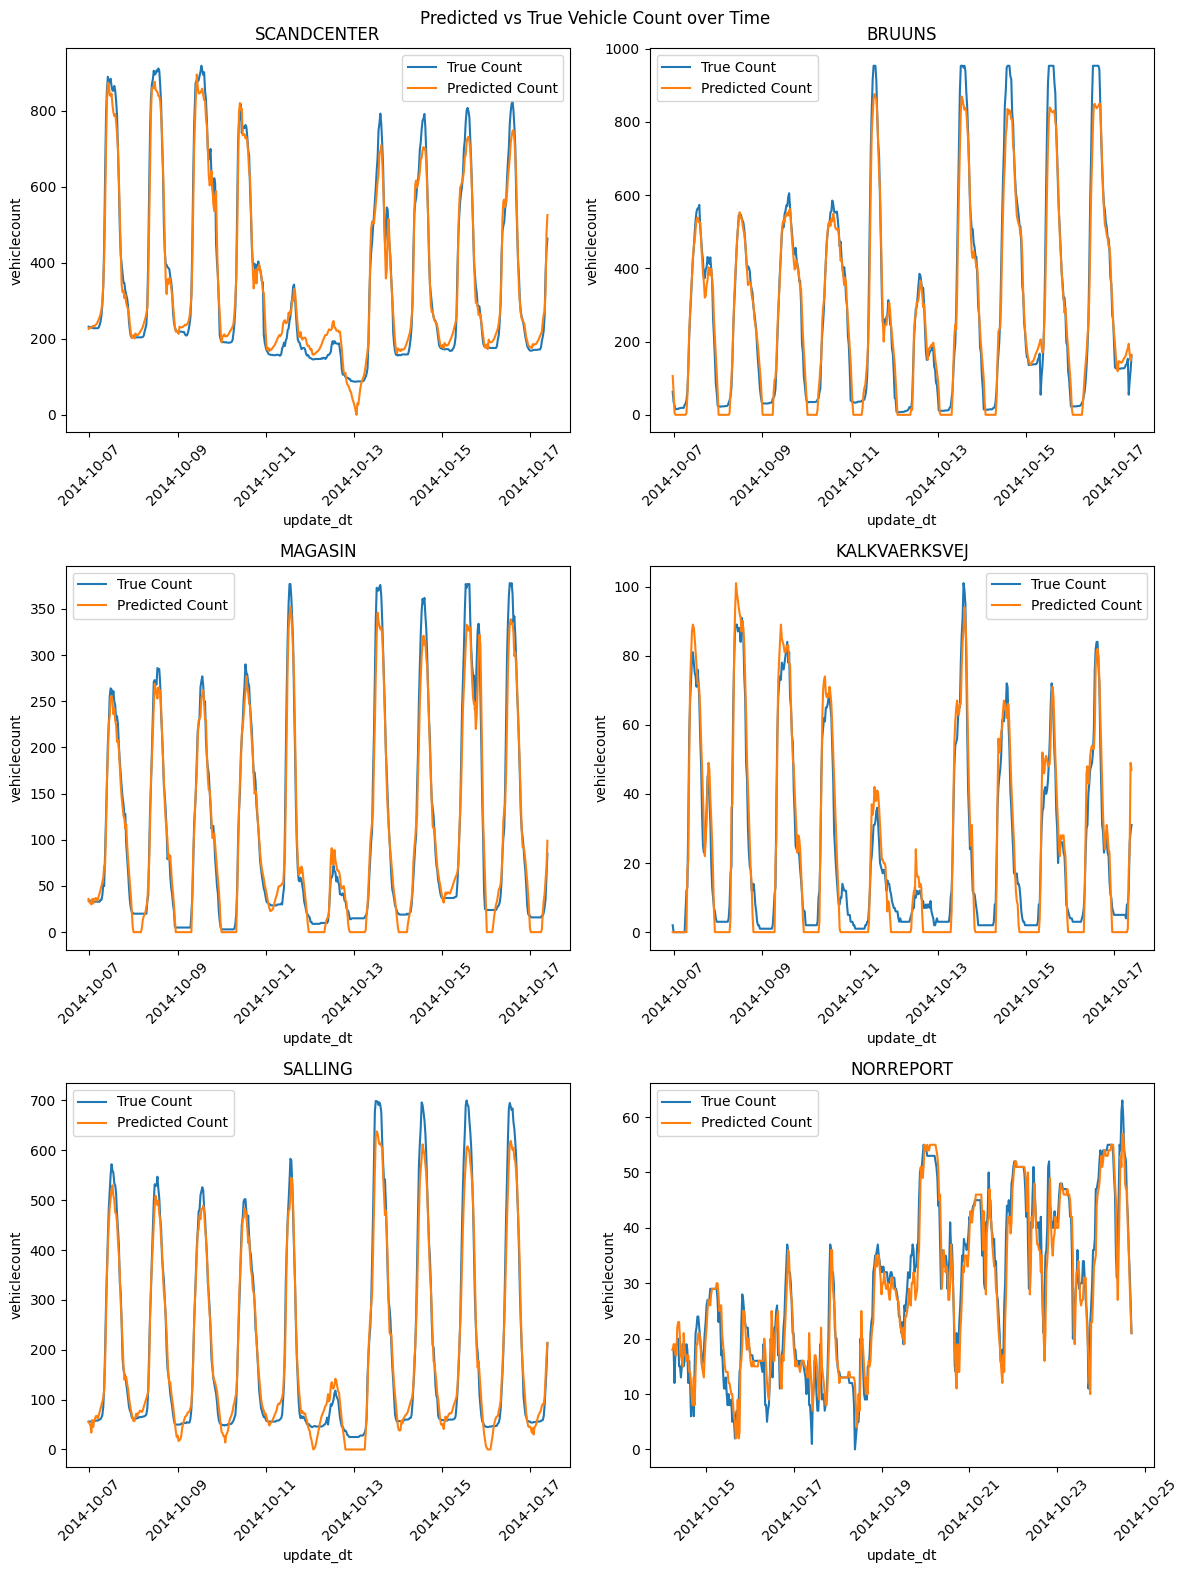

In [149]:
# plot predictions
row_count = 3
col_count = 2
n_predictions = 500

fig, axes = plt.subplots(nrows=row_count, ncols=col_count, figsize=(12,16))

for i, garage in enumerate(unique_garagecodes):
    row = i // col_count
    col = i % col_count
    filtered_df = export_df[export_df['garagecode'] == garage].head(n_predictions)

    sns.lineplot(x='update_dt', y='vehiclecount', data=filtered_df, ax=axes[row, col], label='True Count')
    sns.lineplot(x='update_dt', y='predicted_vehicle_count', data=filtered_df, ax=axes[row, col], label='Predicted Count')
    axes[row, col].set_title(garage)
    axes[row, col].tick_params(axis='x', rotation=45)


plt.suptitle('Predicted vs True Vehicle Count over Time')
plt.tight_layout()
plt.show()

In [160]:
export_df

,vehiclecount,totalspaces,garagecode,update_dt,capacity,prediction,predicted_vehicle_count,predicted_available_spaces,available_spaces
0,232,1240,SCANDCENTER,2014-10-06 23:31:50.203,0.187097,0.182972,226,1014,1008
1,231,1240,SCANDCENTER,2014-10-07 00:01:50.213,0.186290,0.186037,230,1010,1009
2,231,1240,SCANDCENTER,2014-10-07 00:31:50.227,0.186290,0.185480,229,1011,1009
3,230,1240,SCANDCENTER,2014-10-07 01:01:50.212,0.185484,0.184872,229,1011,1010
4,230,1240,SCANDCENTER,2014-10-07 01:31:50.204,0.185484,0.188282,233,1007,1010
...,...,...,...,...,...,...,...,...,...
7879,28,65,NORREPORT,2014-11-04 09:43:47.589,0.430769,0.406508,26,39,37
7880,31,65,NORREPORT,2014-11-04 10:13:47.590,0.476923,0.510436,33,32,34
7881,37,65,NORREPORT,2014-11-04 10:59:35.090,0.569231,0.541174,35,30,28
7882,34,65,NORREPORT,2014-11-04 11:13:47.572,0.523077,0.577061,37,28,31


In [185]:
for garage in unique_garagecodes:
    last_row_index = export_df.loc[export_df['garagecode'] == garage].index[-1]
    export_df.loc[last_row_index, 'capacity'] = None
    export_df.loc[last_row_index, 'vehiclecount'] = None
    export_df.loc[last_row_index, 'available_spaces'] = None

In [186]:
export_df.to_csv('dataset_w_preds.csv', index = None)

In [22]:
export_df = pd.read_csv('dataset_w_preds.csv')

In [23]:
export_df['update_dt'] = pd.to_datetime(export_df['update_dt'])

In [26]:
export_df[export_df['update_dt'].dt.date == pd.to_datetime('2014-10-26').date()]

,vehiclecount,totalspaces,garagecode,update_dt,capacity,prediction,predicted_vehicle_count,predicted_available_spaces,available_spaces
911,288.0,1240,SCANDCENTER,2014-10-26 00:28:41.665,0.232258,0.223702,277,963,952.0
912,289.0,1240,SCANDCENTER,2014-10-26 00:58:41.664,0.233065,0.227404,281,959,951.0
913,284.0,1240,SCANDCENTER,2014-10-26 01:28:41.662,0.229032,0.224326,278,962,956.0
914,282.0,1240,SCANDCENTER,2014-10-26 01:58:41.665,0.227419,0.220077,272,968,958.0
915,282.0,1240,SCANDCENTER,2014-10-26 02:28:41.664,0.227419,0.216531,268,972,958.0
...,...,...,...,...,...,...,...,...,...
7468,48.0,65,NORREPORT,2014-10-26 21:58:41.669,0.738462,0.693178,45,20,17.0
7469,49.0,65,NORREPORT,2014-10-26 22:28:41.670,0.753846,0.723748,47,18,16.0
7470,49.0,65,NORREPORT,2014-10-26 22:58:41.674,0.753846,0.749627,48,17,16.0
7471,48.0,65,NORREPORT,2014-10-26 23:28:41.672,0.738462,0.741958,48,17,17.0
